<a href="https://colab.research.google.com/github/Vidushi-pandit/Photo-or-Text-to-3D-Model-Generator/blob/main/Internship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchvision pillow opencv-python


Initializing...
Initialized!
Enter 'image' to upload or URL, or 'text' to generate from prompt: text
Enter prompt (e.g., 'Anthropomorphic robot fox'): cake
Processing text to 3D: cake
Generating image from text: cake
Processing image from: output/generated_image.png
Removing background...
Original image (without background) saved to output/original_image.png
Generated 3D viewer at: output/index.html


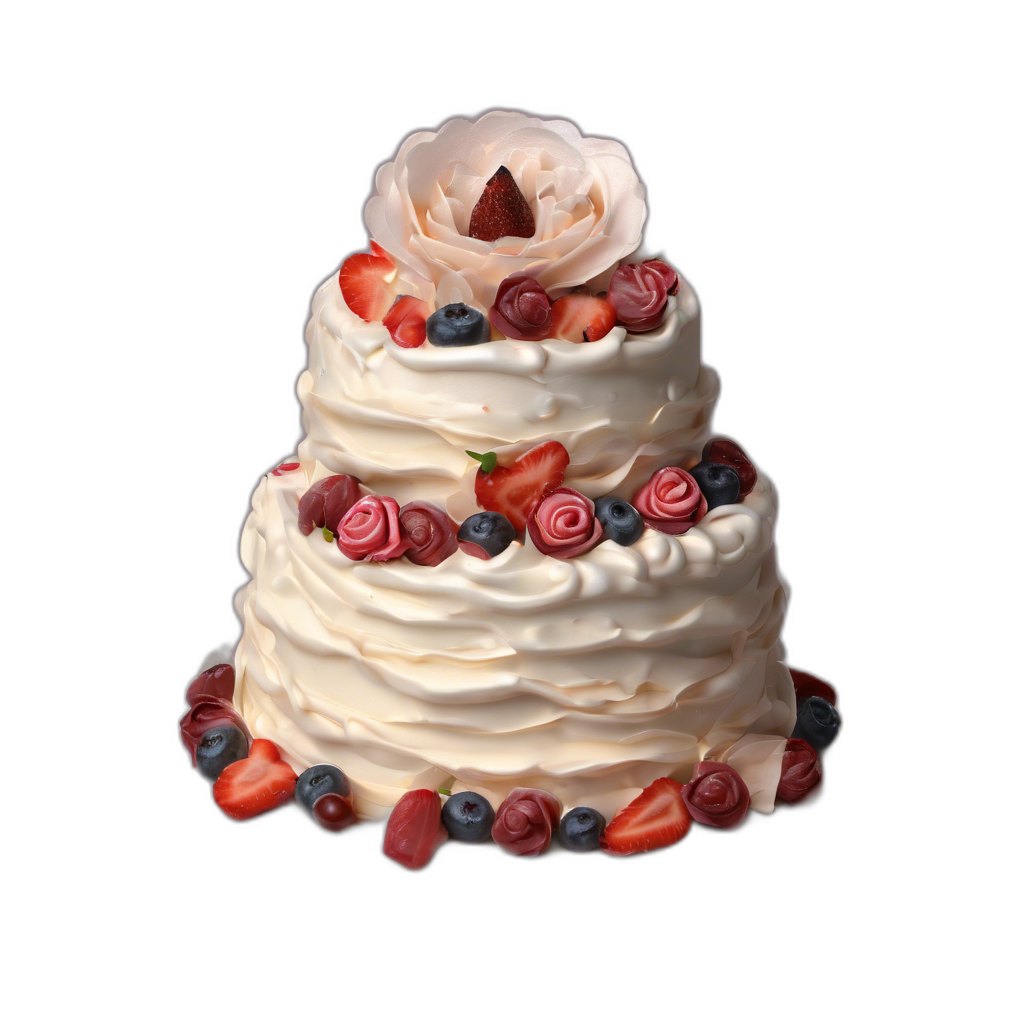

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import json
import base64
import time
from google.colab import files
from IPython.display import display, Image as IPImage

# Install dependencies for background removal
!pip install rembg
!pip install onnxruntime

try:
    from rembg import remove
except ImportError as e:
    print(f"Failed to import rembg: {e}")
    print("Please ensure rembg and onnxruntime are installed correctly.")
    raise

# Create output directory
os.makedirs('output', exist_ok=True)

class PhotoTextTo3D:
    def __init__(self):
        print("Initializing...")
        # Replace with your actual API key
        self.stability_api_key = "sk-gK9fbolKEcWna5lh3UrvhBbPktmtz3UTSTSkoB0uwmY2uQP8"
        print("Initialized!")

    def remove_background(self, image):
        print("Removing background...")
        try:
            # Convert PIL image to bytes for rembg
            img_byte_arr = BytesIO()
            image.save(img_byte_arr, format='PNG')
            img_byte_arr = img_byte_arr.getvalue()

            # Remove background using rembg
            output_img = remove(img_byte_arr)

            # Convert back to PIL image
            image_with_transparent_bg = Image.open(BytesIO(output_img))
            return image_with_transparent_bg
        except Exception as e:
            print(f"Error during background removal: {e}")
            return None

    def process_image(self, image_path, prompt="Anthropomorphic character"):
        print(f"Processing image from: {image_path}")
        try:
            if image_path.startswith('data:image'):
                base64_string = image_path.split(',')[1]
                image_data = base64.b64decode(base64_string)
                image = Image.open(BytesIO(image_data))
            elif image_path.startswith(('http://', 'https://')):
                response = requests.get(image_path)
                response.raise_for_status()
                image = Image.open(BytesIO(response.content))
            else:
                if not os.path.exists(image_path):
                    print(f"Error: Local file not found: {image_path}")
                    return None, None
                image = Image.open(image_path)

            # Convert to RGBA if necessary
            if image.mode != 'RGBA':
                image = image.convert('RGBA')

            # Remove background
            image = self.remove_background(image)
            if image is None:
                print("Background removal failed, aborting.")
                return None, None

            original_path = "output/original_image.png"
            image.save(original_path)
            print(f"Original image (without background) saved to {original_path}")

            buffered = BytesIO()
            image.save(buffered, format="PNG")
            img_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
            texture_data_url = f"data:image/png;base64,{img_base64}"

            html_path = self._create_3d_viewer(texture_data_url, prompt)
            return html_path, original_path if html_path else (None, original_path)
        except Exception as e:
            print(f"Error processing image: {e}")
            return None, None

    def generate_image_from_text(self, text_prompt):
        print(f"Generating image from text: {text_prompt}")
        try:
            if self.stability_api_key:
                return self._generate_image_with_stability_ai(text_prompt)
            else:
                print("Stability AI API key not configured")
                return None
        except Exception as e:
            print(f"Error generating image from text: {e}")
            return None

    def _generate_image_with_stability_ai(self, text_prompt):
        try:
            url = "https://api.stability.ai/v1/generation/stable-diffusion-xl-1024-v1-0/text-to-image"
            headers = {
                "Authorization": f"Bearer {self.stability_api_key}",
                "Content-Type": "application/json",
                "Accept": "application/json"
            }
            payload = {
                "text_prompts": [
                    {
                        "text": f"{text_prompt}, high quality, detailed, single object, centered, transparent background",
                        "weight": 1.0
                    }
                ],
                "cfg_scale": 7,
                "height": 1024,
                "width": 1024,
                "samples": 1,
                "steps": 30
            }

            response = requests.post(url, headers=headers, json=payload)
            if response.status_code == 200:
                data = response.json()
                for image in data["artifacts"]:
                    image_data = base64.b64decode(image["base64"])
                    image_path = "output/generated_image.png"
                    with open(image_path, "wb") as f:
                        f.write(image_data)
                    return image_path
            else:
                print(f"Error from Stability AI: {response.text}")
                return None
        except Exception as e:
            print(f"Error with Stability AI API: {e}")
            return None

    def process_text_to_3d(self, text_prompt):
        print(f"Processing text to 3D: {text_prompt}")
        image_path = self.generate_image_from_text(text_prompt)
        return self.process_image(image_path, text_prompt) if image_path else (None, None)

    def _create_3d_viewer(self, texture_data_url, prompt):
        try:
            html_template = f"""
<!DOCTYPE html>
<html>
<head>
    <meta charset="UTF-8">
    <title>3D Image Viewer</title>
    <style>
        html, body {{ margin: 0; height: 100%; background-color: #222; }}
        canvas {{ width: 100%; height: 100%; }}
    </style>
</head>
<body>
    <script src="https://cdnjs.cloudflare.com/ajax/libs/three.js/r134/three.min.js"></script>
    <script src="https://cdn.jsdelivr.net/npm/three@0.134.0/examples/js/controls/OrbitControls.js"></script>
    <script>
        // Initialize scene, camera, and renderer
        const scene = new THREE.Scene();
        const camera = new THREE.PerspectiveCamera(75, window.innerWidth / window.innerHeight, 0.1, 1000);
        const renderer = new THREE.WebGLRenderer({{ antialias: true, alpha: true }});
        renderer.setSize(window.innerWidth, window.innerHeight);
        renderer.setClearColor(0x000000, 0); // Transparent background
        document.body.appendChild(renderer.domElement);

        // Add orbit controls
        const controls = new THREE.OrbitControls(camera, renderer.domElement);
        controls.enableDamping = true;
        controls.dampingFactor = 0.05;

        // Add lighting
        const directionalLight = new THREE.DirectionalLight(0xffffff, 0.8);
        directionalLight.position.set(5, 5, 5);
        scene.add(directionalLight);
        const ambientLight = new THREE.AmbientLight(0x404040, 0.5);
        scene.add(ambientLight);

        // Load texture and create heightmap
        const texLoader = new THREE.TextureLoader();
        texLoader.load('{texture_data_url}', (texture) => {{
            texture.minFilter = THREE.LinearFilter;
            texture.magFilter = THREE.LinearFilter;

            // Create plane geometry
            const width = 2;
            const height = 2;
            const widthSegments = 64;
            const heightSegments = 64;
            const geometry = new THREE.PlaneGeometry(width, height, widthSegments, heightSegments);

            // Create material with texture and displacement
            const material = new THREE.MeshPhongMaterial({{
                map: texture,
                displacementMap: texture,
                displacementScale: 0.5,
                side: THREE.DoubleSide,
                transparent: true
            }});

            // Create mesh
            const mesh = new THREE.Mesh(geometry, material);
            scene.add(mesh);

            // Rotate plane to face camera
            mesh.rotation.x = -Math.PI / 2;
        }});

        // Set camera position
        camera.position.set(0, 1, 2);
        camera.lookAt(0, 0, 0);

        // Animation loop
        function animate() {{
            requestAnimationFrame(animate);
            controls.update();
            renderer.render(scene, camera);
        }}
        animate();

        // Handle window resize
        window.addEventListener('resize', () => {{
            camera.aspect = window.innerWidth / window.innerHeight;
            camera.updateProjectionMatrix();
            renderer.setSize(window.innerWidth, window.innerHeight);
        }});
    </script>
</body>
</html>
"""
            html_path = "output/index.html"
            with open(html_path, "w") as f:
                f.write(html_template)
            return html_path
        except Exception as e:
            print(f"Error creating viewer: {e}")
            return None

def main():
    converter = PhotoTextTo3D()
    input_type = input("Enter 'image' to upload or URL, or 'text' to generate from prompt: ").strip().lower()

    if input_type == 'image':
        print("Upload image file:")
        uploaded = files.upload()
        if uploaded:
            img_path = list(uploaded.keys())[0]
            html_path, original = converter.process_image(img_path)
        else:
            url = input("Enter image URL: ")
            html_path, original = converter.process_image(url)
    elif input_type == 'text':
        prompt = input("Enter prompt (e.g., 'Anthropomorphic robot fox'): ")
        html_path, original = converter.process_text_to_3d(prompt)
    else:
        print("Invalid input.")
        return

    if html_path:
        print(f"Generated 3D viewer at: {html_path}")
        display(IPImage(filename=original))
        files.download(html_path)
    else:
        print("Failed to generate output.")

main()